<a href="https://colab.research.google.com/github/0xilham/0xilham/blob/main/Crypto_Prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance pandas numpy matplotlib seaborn scikit-learn tensorflow

In [2]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('fivethirtyeight')

In [3]:
# Download cryptocurrency data
def download_crypto_data(symbol, period="5y", interval="1d"): # default: period="2y", interval="1d"
    """
    Download cryptocurrency data from Yahoo Finance
    """
    crypto = yf.download(symbol, period=period, interval=interval)
    return crypto

# Example: Bitcoin data
symbol = "BTC-USD"  # You can change to other cryptocurrencies: BTC-USD, ETH-USD, ADA-USD, etc.
data = download_crypto_data(symbol)
print(f"Data shape: {data.shape}")
data.head()

[*********************100%***********************]  1 of 1 completed

Data shape: (1826, 5)


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2021-02-18,51679.796875,52474.105469,51015.765625,52140.972656,52054723579
2021-02-19,55888.132812,56113.652344,50937.277344,51675.980469,63495496918
2021-02-20,56099.519531,57505.226562,54626.558594,55887.335938,68145460026
2021-02-21,57539.945312,58330.570312,55672.609375,56068.566406,51897585191
2021-02-22,54207.320312,57533.390625,48967.566406,57532.738281,92052420332


Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2021-02-18 to 2026-02-18
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BTC-USD)   1826 non-null   float64
 1   (High, BTC-USD)    1826 non-null   float64
 2   (Low, BTC-USD)     1826 non-null   float64
 3   (Open, BTC-USD)    1826 non-null   float64
 4   (Volume, BTC-USD)  1826 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 85.6 KB
None

Data Description:
Price           Close           High            Low           Open  \
Ticker        BTC-USD        BTC-USD        BTC-USD        BTC-USD   
count     1826.000000    1826.000000    1826.000000    1826.000000   
mean     55621.240484   56664.031071   54474.158467   55613.967292   
std      29720.343753   30134.381755   29264.294808   29718.785409   
min      15787.284180   16253.047852   15599.046875   15782.300781   
25%      29410.323730   29988.9023

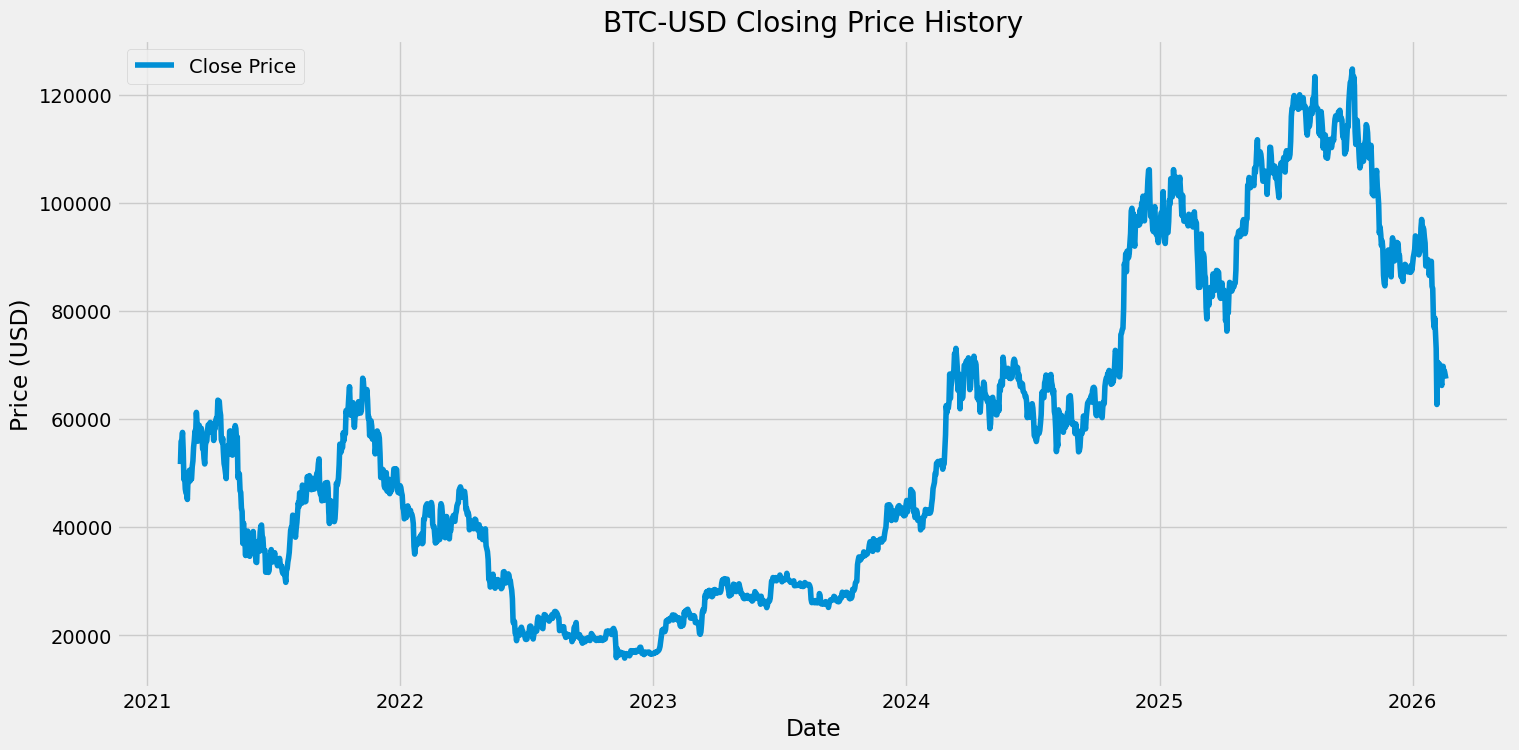

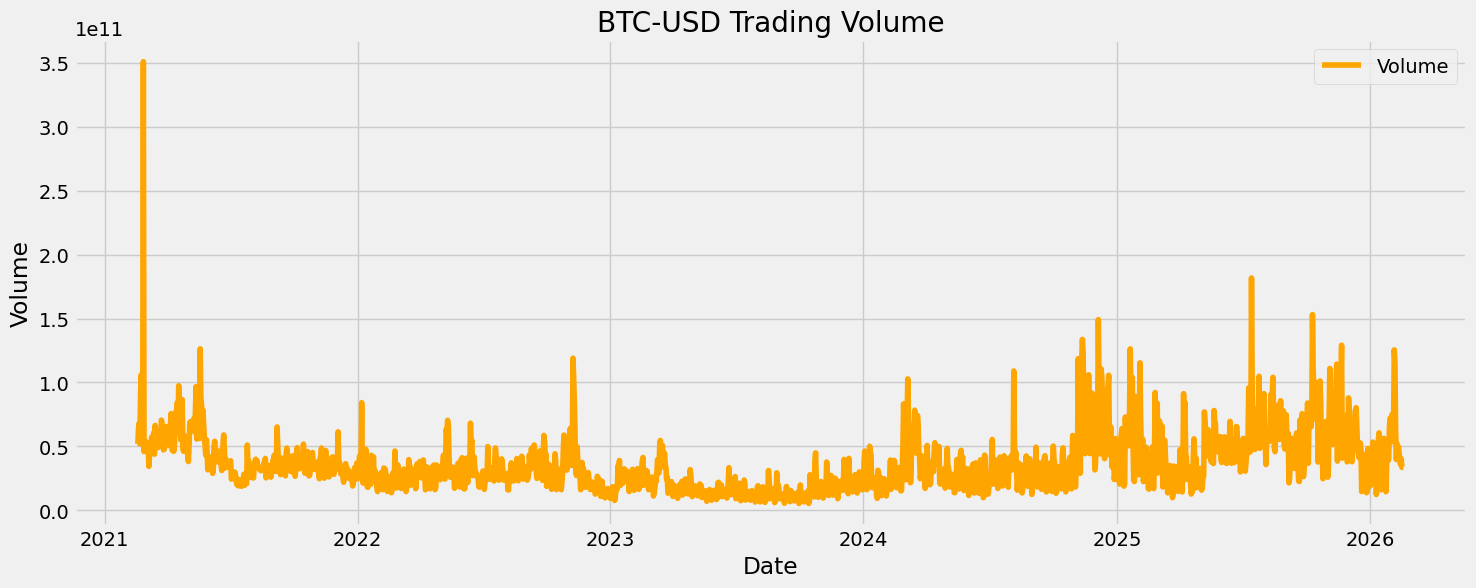

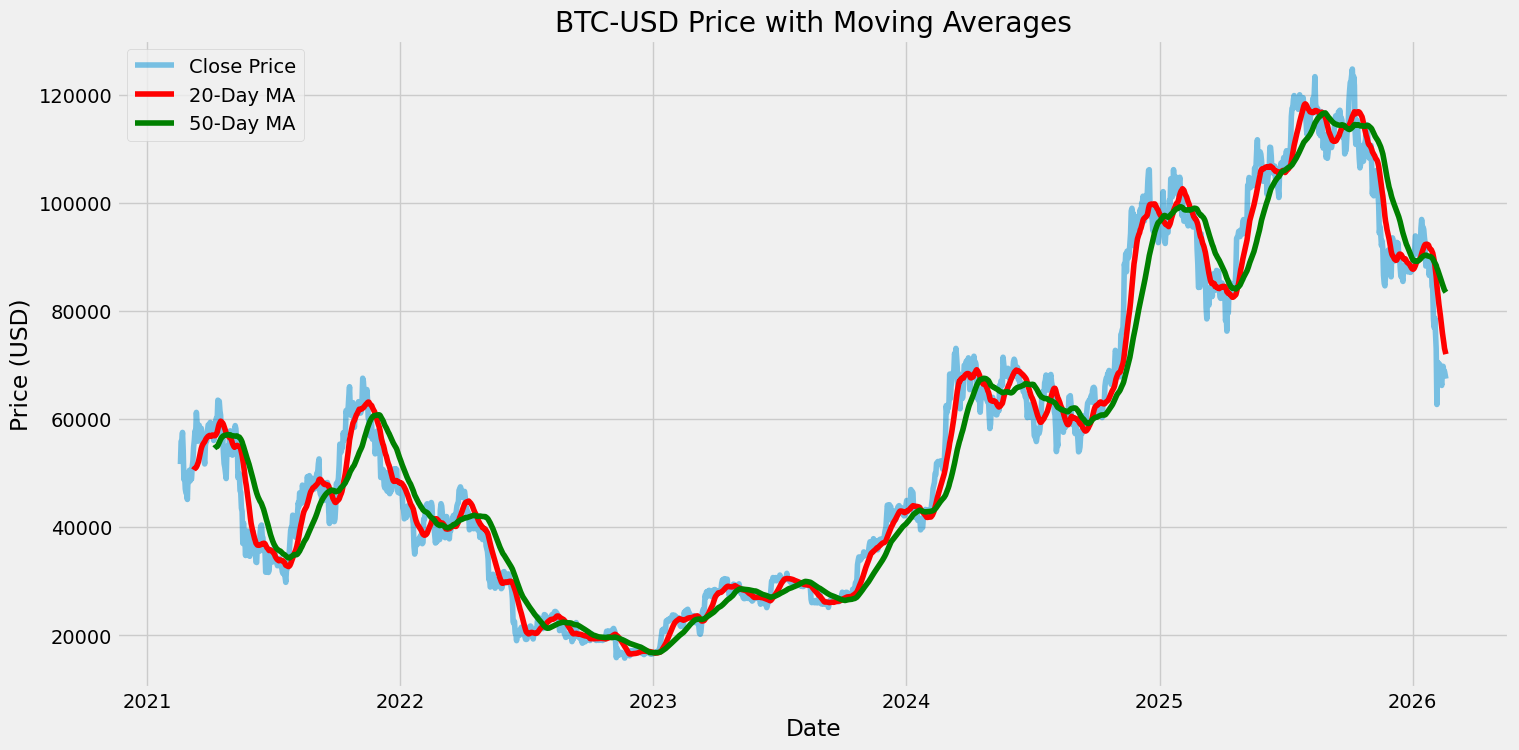

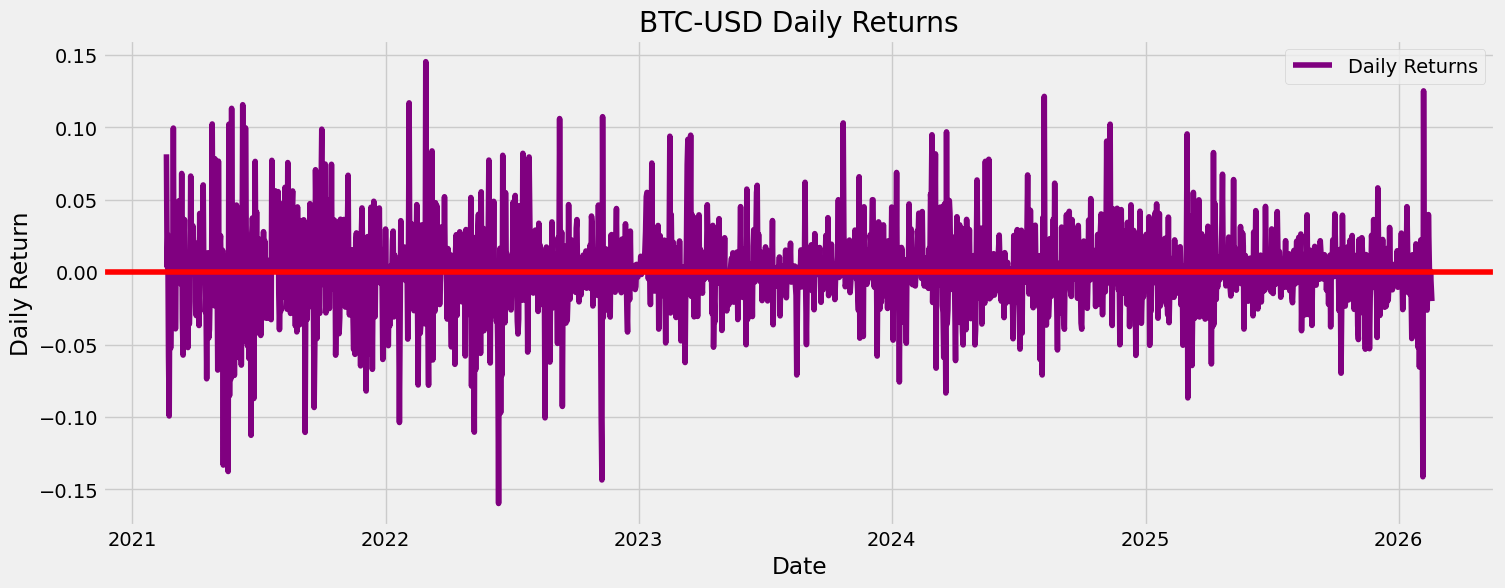

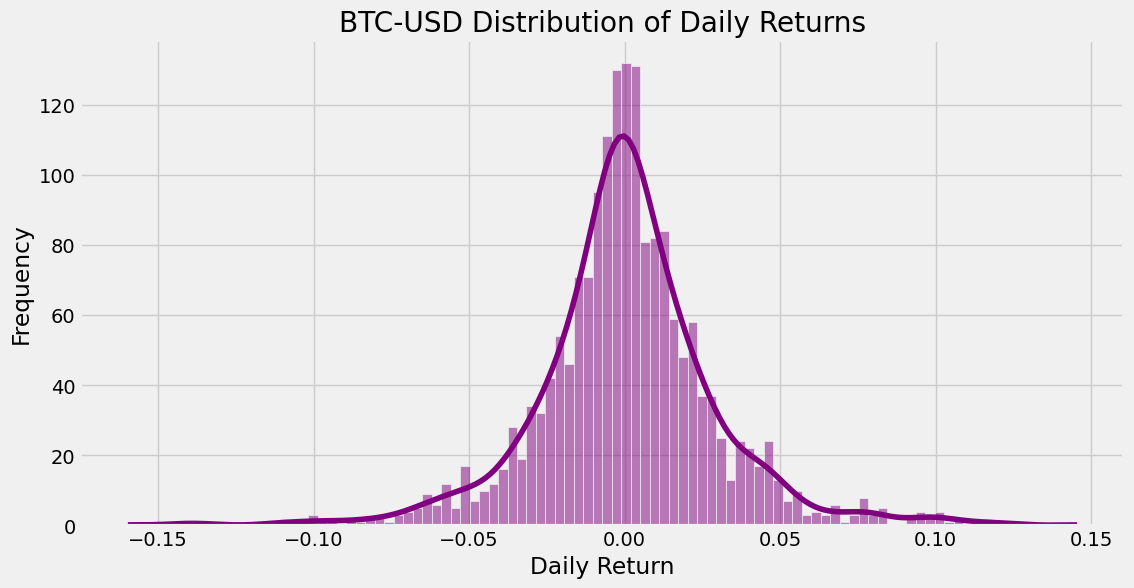

In [4]:
# Basic information about the data
print("Data Info:")
print(data.info())
print("\nData Description:")
print(data.describe())

# Plot closing price
plt.figure(figsize=(16, 8))
plt.plot(data['Close'], label='Close Price')
plt.title(f'{symbol} Closing Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Plot volume
plt.figure(figsize=(16, 6))
plt.plot(data['Volume'], label='Volume', color='orange')
plt.title(f'{symbol} Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

# Calculate moving averages
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()

# Plot moving averages
plt.figure(figsize=(16, 8))
plt.plot(data['Close'], label='Close Price', alpha=0.5)
plt.plot(data['MA20'], label='20-Day MA', color='red')
plt.plot(data['MA50'], label='50-Day MA', color='green')
plt.title(f'{symbol} Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Calculate daily returns
data['Daily Return'] = data['Close'].pct_change()

# Plot daily returns
plt.figure(figsize=(16, 6))
plt.plot(data['Daily Return'], label='Daily Returns', color='purple')
plt.title(f'{symbol} Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.axhline(y=0, color='r', linestyle='-')
plt.legend()
plt.show()

# Distribution of daily returns
plt.figure(figsize=(12, 6))
sns.histplot(data['Daily Return'].dropna(), bins=100, color='purple', kde=True)
plt.title(f'{symbol} Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

In [5]:
# Prepare data for LSTM
def prepare_data(data, lookback=60):
    """
    Prepare data for LSTM model
    """
    # Use only closing price
    dataset = data['Close'].values
    dataset = dataset.reshape(-1, 1)

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    # Create training data
    training_data_len = int(len(scaled_data) * 0.8)
    train_data = scaled_data[0:training_data_len, :]

    # Create the training datasets
    x_train = []
    y_train = []

    for i in range(lookback, len(train_data)):
        x_train.append(train_data[i-lookback:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Create the testing datasets
    test_data = scaled_data[training_data_len - lookback:, :]
    x_test = []
    y_test = dataset[training_data_len:, :]

    for i in range(lookback, len(test_data)):
        x_test.append(test_data[i-lookback:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return x_train, y_train, x_test, y_test, scaler, training_data_len

# Prepare the data
lookback = 60  # 60 days lookback period
x_train, y_train, x_test, y_test, scaler, training_data_len = prepare_data(data, lookback)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (1400, 60, 1)
y_train shape: (1400,)
x_test shape: (366, 60, 1)
y_test shape: (366, 1)


In [6]:
# Build LSTM model
def build_lstm_model(input_shape):
    """
    Build and compile LSTM model
    """
    model = Sequential()

    # First LSTM layer
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))

    # Second LSTM layer
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))

    # Third LSTM layer
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))

    # Fourth LSTM layer
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mean_squared_error')

    return model

# Build the model
model = build_lstm_model((x_train.shape[1], 1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - loss: 0.0206 - val_loss: 0.0077
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.0026 - val_loss: 0.0053
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - loss: 0.0020 - val_loss: 0.0070
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 0.0022 - val_loss: 0.0069
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 0.0017 - val_loss: 0.0106
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 0.0016 - val_loss: 0.0067
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - loss: 0.0016 - val_loss: 0.0079
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.0015 - val_loss: 0.0060
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.0015 - val_loss: 0.0047
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - loss: 0.0015 - val_loss: 0.0057
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 

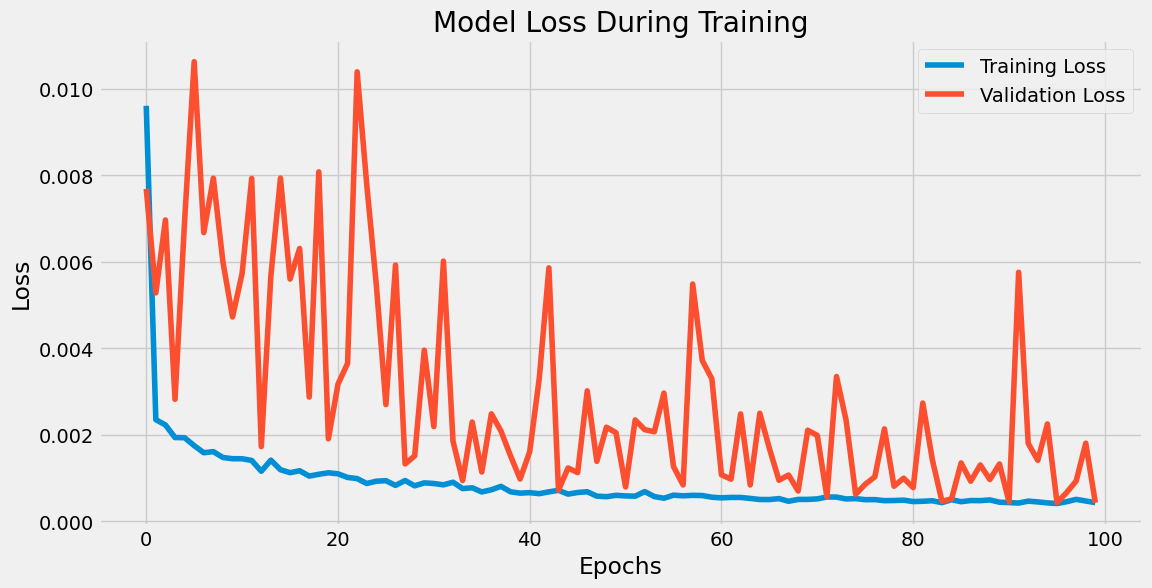

In [7]:
# Train the model
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=100,
                    validation_split=0.1,
                    verbose=1)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step
Root Mean Squared Error: 2415.894025887788
Mean Absolute Error: 1825.5994386099726


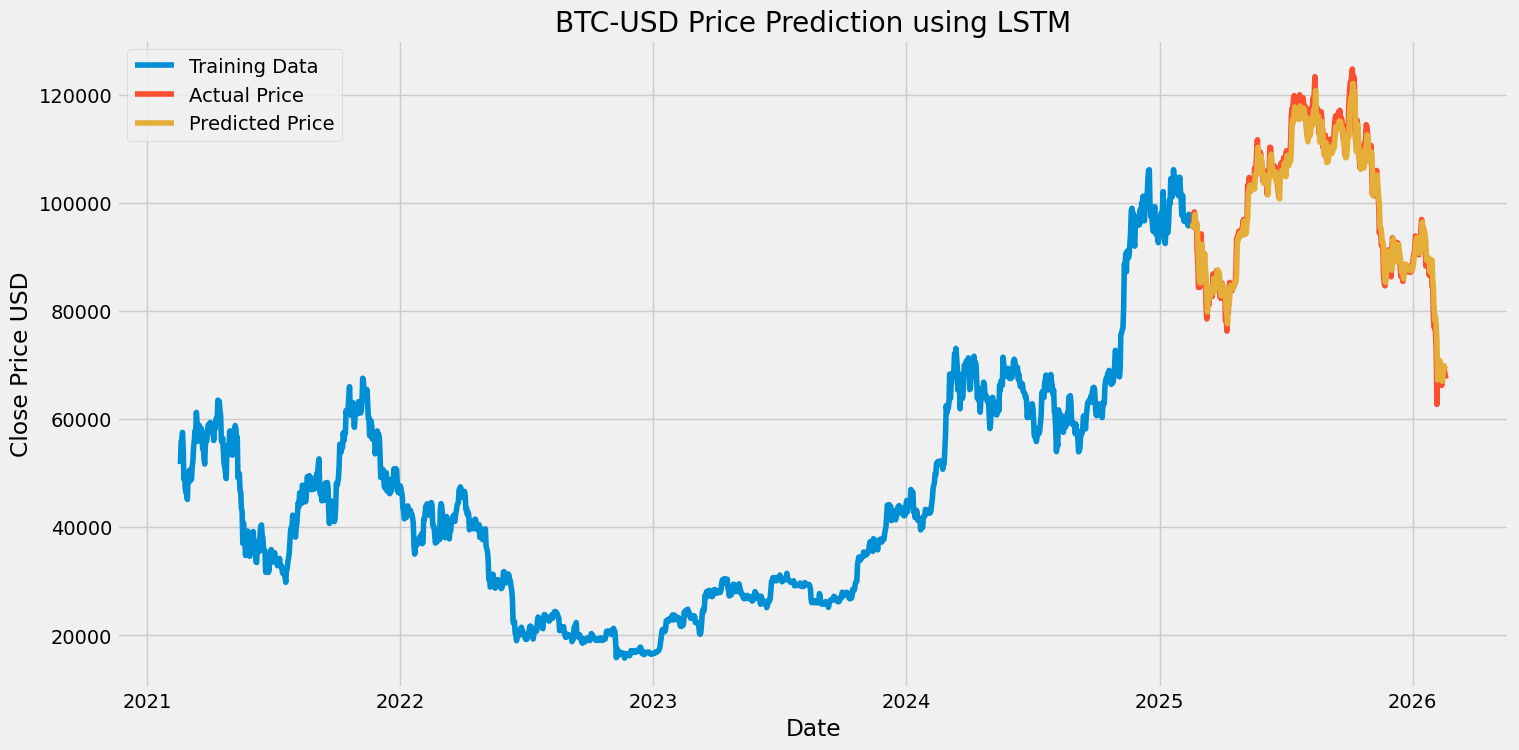

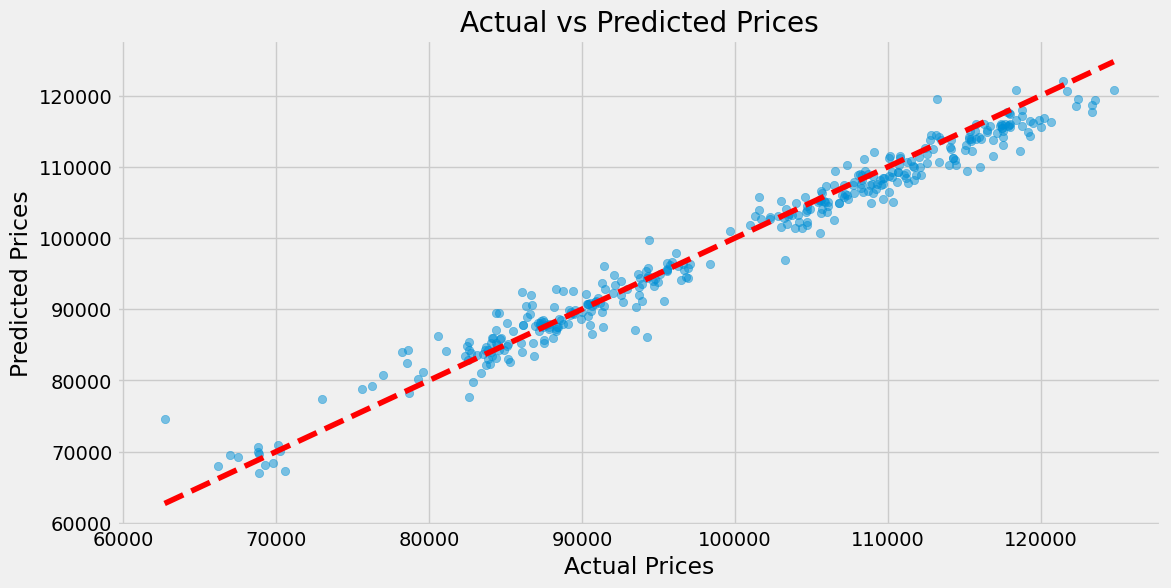

In [8]:
# Make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error: {rmse}')

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error: {mae}')

# Create dataframe for plotting
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Plot the results
plt.figure(figsize=(16, 8))
plt.title(f'{symbol} Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price USD')

plt.plot(train['Close'], label='Training Data')
plt.plot(valid['Close'], label='Actual Price')
plt.plot(valid['Predictions'], label='Predicted Price')

plt.legend()
plt.show()

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()

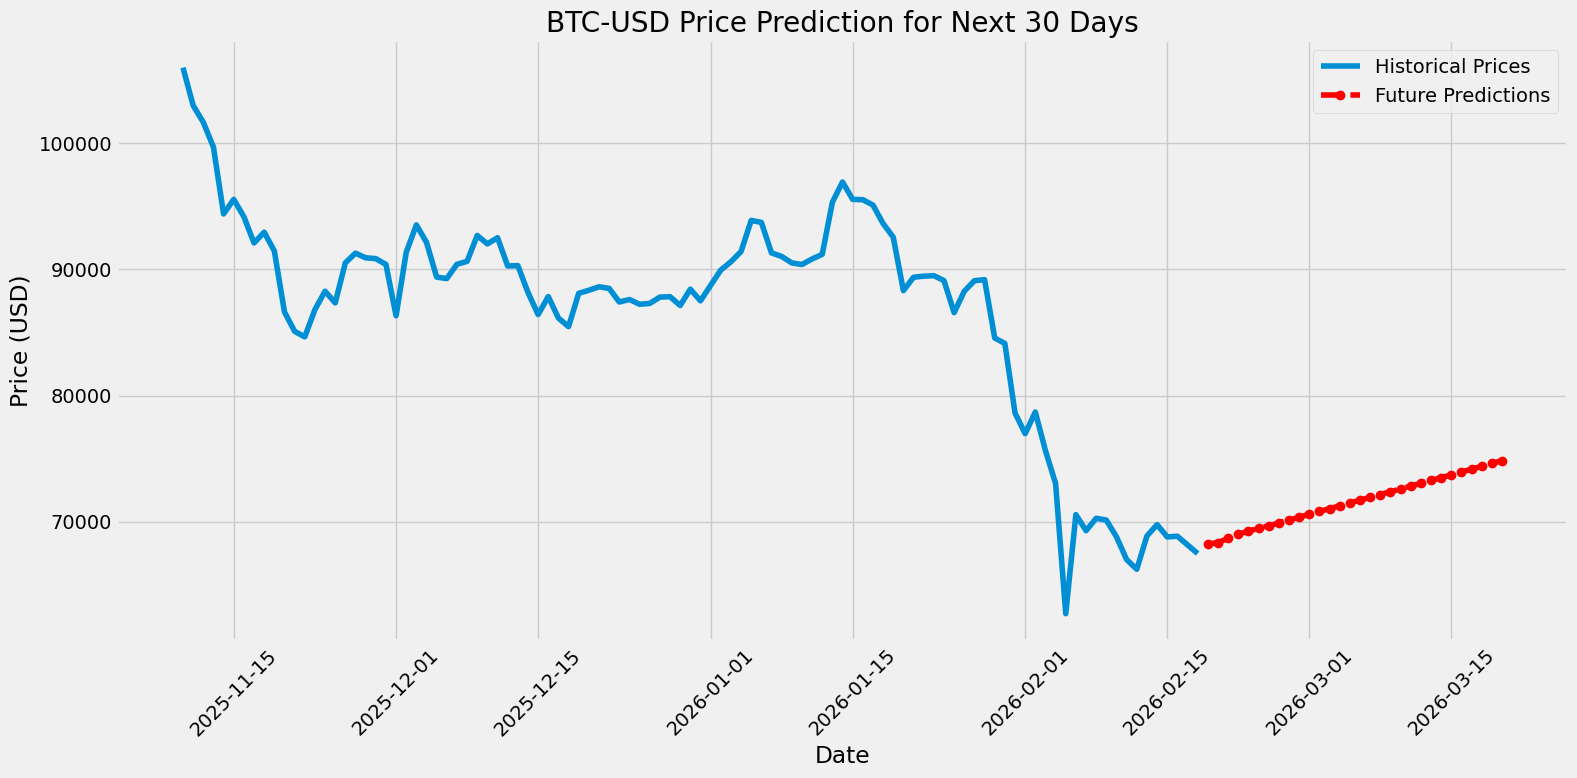

Predicted prices for next 30 days:
Day 1 (2026-02-19): $68232.37
Day 2 (2026-02-20): $68323.14
Day 3 (2026-02-21): $68682.13
Day 4 (2026-02-22): $69003.57
Day 5 (2026-02-23): $69249.56
Day 6 (2026-02-24): $69461.74
Day 7 (2026-02-25): $69673.35
Day 8 (2026-02-26): $69894.38
Day 9 (2026-02-27): $70122.12
Day 10 (2026-02-28): $70351.63
Day 11 (2026-03-01): $70580.00
Day 12 (2026-03-02): $70806.52
Day 13 (2026-03-03): $71031.48
Day 14 (2026-03-04): $71255.42
Day 15 (2026-03-05): $71478.74
Day 16 (2026-03-06): $71701.69
Day 17 (2026-03-07): $71924.47
Day 18 (2026-03-08): $72147.23
Day 19 (2026-03-09): $72370.06
Day 20 (2026-03-10): $72593.12
Day 21 (2026-03-11): $72816.47
Day 22 (2026-03-12): $73040.14
Day 23 (2026-03-13): $73264.16
Day 24 (2026-03-14): $73488.51
Day 25 (2026-03-15): $73713.22
Day 26 (2026-03-16): $73938.23
Day 27 (2026-03-17): $74163.50
Day 28 (2026-03-18): $74388.97
Day 29 (2026-03-19): $74614.60
Day 30 (2026-03-20): $74840.32


In [9]:
def predict_future(model, data, scaler, lookback=60, days=30):
    """
    Predict future prices
    """
    # Get the last lookback days from the data
    last_60_days = data['Close'][-lookback:].values
    last_60_days_scaled = scaler.transform(last_60_days.reshape(-1, 1))

    future_predictions = []
    current_batch = last_60_days_scaled.reshape(1, lookback, 1)

    for i in range(days):
        # Get prediction
        current_pred = model.predict(current_batch, verbose=0)[0]
        future_predictions.append(current_pred)

        # Update batch
        current_batch = np.append(current_batch[:, 1:, :],
                                 [[current_pred]], axis=1)

    # Inverse transform predictions
    future_predictions = scaler.inverse_transform(future_predictions)

    return future_predictions

# Predict next 30 days
future_days = 30
future_predictions = predict_future(model, data, scaler, lookback, future_days)

# Create future dates
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                            periods=future_days, freq='D')

# Plot future predictions
plt.figure(figsize=(16, 8))
plt.plot(data['Close'][-100:], label='Historical Prices')
plt.plot(future_dates, future_predictions, label='Future Predictions',
         color='red', linestyle='--', marker='o')
plt.title(f'{symbol} Price Prediction for Next {future_days} Days')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Predicted prices for next {future_days} days:")
for i, (date, price) in enumerate(zip(future_dates, future_predictions)):
    print(f"Day {i+1} ({date.strftime('%Y-%m-%d')}): ${price[0]:.2f}")


Mean Absolute Percentage Error (MAPE): 15.74%
Direction Accuracy: 47.95%


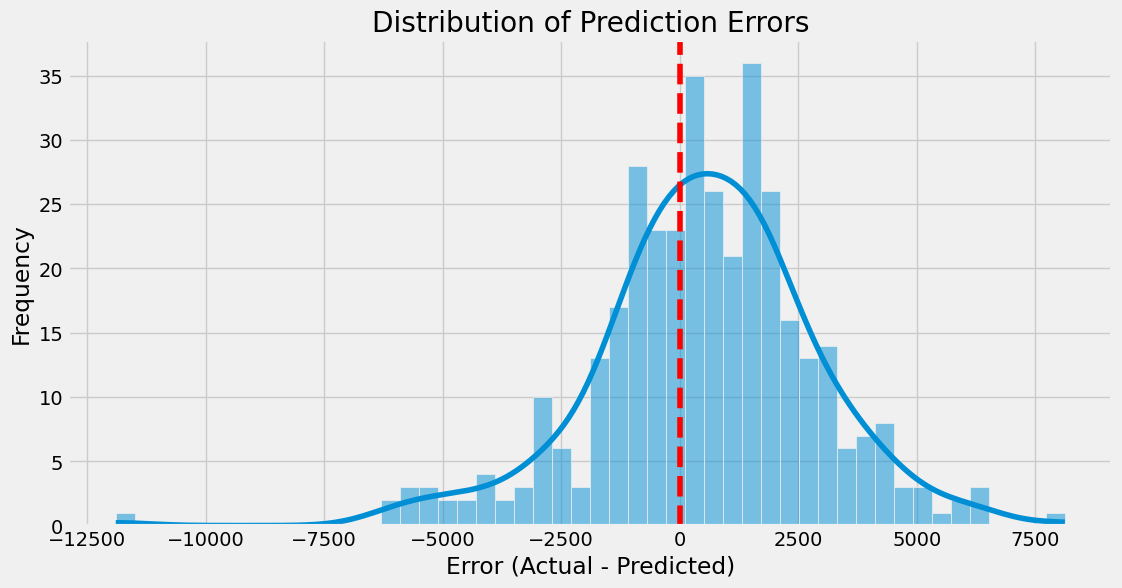

In [10]:
# Additional evaluation metrics
def calculate_metrics(actual, predicted):
    """
    Calculate various evaluation metrics
    """
    # Calculate percentage errors
    percentage_errors = np.abs((actual - predicted.flatten()) / actual) * 100
    mape = np.mean(percentage_errors)

    # Calculate direction accuracy
    actual_direction = np.diff(actual.flatten())
    predicted_direction = np.diff(predicted.flatten())
    direction_accuracy = np.mean((actual_direction * predicted_direction) > 0) * 100

    return mape, direction_accuracy

mape, direction_accuracy = calculate_metrics(y_test, predictions)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'Direction Accuracy: {direction_accuracy:.2f}%')

# Plot error distribution
errors = y_test.flatten() - predictions.flatten()
plt.figure(figsize=(12, 6))
sns.histplot(errors, bins=50, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r', linestyle='--')
plt.show()